<a href="https://colab.research.google.com/github/Lee-Gunju/AI-paper-code-review-for-personal-project/blob/master/WGAN_GP_overriding_Model_train_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


In [ ]:
IMG_SHAPE = (28, 28, 1)
BATCH_SIZE = 512

# Size of the noise vector
noise_dim = 128

fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()
print(f"Number of examples: {len(train_images)}")
print(f"Shape of the images in the dataset: {train_images.shape[1:]}")

# Reshape each sample to (28, 28, 1) and normalize the pixel values in the [-1, 1] range
train_images = train_images.reshape(train_images.shape[0], *IMG_SHAPE).astype("float32")
train_images = (train_images - 127.5) / 127.5

4423680/4422102 [==============================] - 0s 0us/step
Number of examples: 60000
Shape of the images in the dataset: (28, 28)


In [ ]:
train_images.shape

(60000, 28, 28, 1)

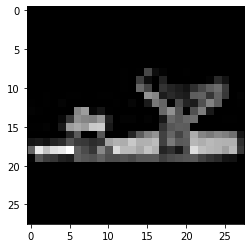

In [ ]:
plt.imshow(train_images[59999][:,:,0], cmap='gray')

In [ ]:
def conv_block(x, filters, activation, kernel_size= (3,3), strides = (1,1), padding = 'same', use_bias=True, use_bn = False, use_dropout = False, drop_value = 0.5):
  x = layers.Conv2D(filters, kernel_size, strides=strides, padding=padding, use_bias=use_bias)(x)
  if use_bn:
    x = layers.BatchNormalization()(x)
  x = activation(x)
  if use_dropout:
    x = layers.Dropout(drop_value)(x)
  return x 

def get_discriminator_model():
  img_input = layers.Input(shape = IMG_SHAPE)
  # Zero pad the input to make the input images size to (32, 32, 1).
  x = layers.ZeroPadding2D((2,2))(img_input)
  x = conv_block(x, 64, kernel_size = (5,5), strides = (2,2), use_bn = False, use_bias = True, activation=layers.LeakyReLU(0.2), use_dropout=False, drop_value=0.3)
  x = conv_block(
        x,
        128,
        kernel_size=(5, 5),
        strides=(2, 2),
        use_bn=False,
        activation=layers.LeakyReLU(0.2),
        use_bias=True,
        use_dropout=True,
        drop_value=0.3,
    )
  x = conv_block(
      x,
      256,
      kernel_size=(5, 5),
      strides=(2, 2),
      use_bn=False,
      activation=layers.LeakyReLU(0.2),
      use_bias=True,
      use_dropout=True,
      drop_value=0.3,
  )
  x = conv_block(
      x,
      512,
      kernel_size=(5, 5),
      strides=(2, 2),
      use_bn=False,
      activation=layers.LeakyReLU(0.2),
      use_bias=True,
      use_dropout=False,
      drop_value=0.3,
  )

  x = layers.Flatten()(x)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(1)(x)

  d_model = keras.models.Model(img_input, x, name = 'discriminator')
  return d_model

In [ ]:
d_model = get_discriminator_model()
d_model.summary()

Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 16, 16, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 128)       

In [ ]:
def upsample_block(x, filters, activation, kernel_size = (3,3), strides = (1,1), up_size = (2,2), padding ='same', use_bn = False, use_bias = True, use_dropout = False, drop_value = 0.3):
  x = layers.UpSampling2D(up_size)(x)
  x = layers.Conv2D(filters, kernel_size, strides=strides, padding = padding, use_bias = use_bias)(x)
  if use_bn:
    x = layers.BatchNormalization()(x)
  if activation:
    x = activation(x)
  if use_dropout:
    x = layers.Dropout(drop_value)(x)
  return x 


def get_generator_model():
  noise = layers.Input(shape = (noise_dim,))
  x = layers.Dense(4 * 4 * 256, use_bias=False)(noise)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU(0.2)(x)

  x = layers.Reshape((4, 4, 256))(x)
  x = upsample_block(
        x,
        128,
        layers.LeakyReLU(0.2),
        strides=(1, 1),
        use_bias=False,
        use_bn=True,
        padding="same",
        use_dropout=False,
    )
  x = upsample_block(
      x,
      64,
      layers.LeakyReLU(0.2),
      strides=(1, 1),
      use_bias=False,
      use_bn=True,
      padding="same",
      use_dropout=False,
  )
  x = upsample_block(
      x, 1, layers.Activation("tanh"), strides=(1, 1), use_bias=False, use_bn=True
  )
  # At this point, we have an output which has the same shape as the input, (32, 32, 1).
  # We will use a Cropping2D layer to make it (28, 28, 1).
  x = layers.Cropping2D((2, 2))(x)

  g_model = keras.models.Model(noise, x, name="generator")
  return g_model


g_model = get_generator_model()
g_model.summary()

Model: "generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_2 (Dense)              (None, 4096)              524288    
_________________________________________________________________
batch_normalization_1 (Batch (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         29

In [ ]:
class WGAN(keras.Model):
  def __init__(self, discriminator, generator, latent_dim, discriminator_extra_steps = 3, gp_weight = 10.0):
    super(WGAN, self).__init__()
    self.discriminator = discriminator
    self.generator = generator 
    self.latent_dim = latent_dim
    self.d_steps = discriminator_extra_steps
    self.gp_weight = gp_weight

  def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
    super(WGAN, self).compile()
    self.d_optimizer = d_optimizer 
    self.g_optimizer = g_optimizer 
    self.d_loss_fn = d_loss_fn
    self.g_loss_fn = g_loss_fn 

  def gradient_penalty(self, batch_size, real_images, fake_images):
    """ Calculates the gradient penalty.

    This loss is calculated on an interpolated image
    and added to the discriminator loss.
    """

    # Get the interpolated image
    alpha = tf.random.normal(shape = [batch_size, 1, ,1 ,1], 0.0, 1.0)
    diff = fake_image - real_image 
    interpolated = real_image + alpha * diff 

    with tf.GradientTape() as gp_tape:
      gp_tape.watch(interpolated)
      # 1. Get the discriminator output for this interpolated image.
      pred = self.discriminator(interpolated, training = True)
    
    # 2. Calculate the gradients w.r.t to this interpolated image.
    grads = gp_tape.gradient(pred, [interploated])[0]
    # 3. Calculate the norm of the gradients.
    norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis = [1,2,3]))
    gp = tf.reduce_mean((norm - 1.0) **2)
    return gp 

  def train_step(self, real_images):
    if isinstance(real_images, tuple):
      real_images = real_images[0]

    batch_size = tf.shape(real_images)[0]
    # For each batch, we are going to perform the
    # following steps as laid out in the original paper:
    # 1. Train the generator and get the generator loss
    # 2. Train the discriminator and get the discriminator loss
    # 3. Calculate the gradient penalty
    # 4. Multiply this gradient penalty with a constant weight factor
    # 5. Add the gradient penalty to the discriminator loss
    # 6. Return the generator and discriminator losses as a loss dictionary

    # Train the discriminator first. The original paper recommends training
    # the discriminator for `x` more steps (typically 5) as compared to
    # one step of the generator. Here we will train it

    for i in range(self.d_steps):
      random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

      with tf.GradientTape() as tape:
        fake_images = self.generator(random_latent_vectors, training = True)

        fake_logits = self.discriminator(fake_images, training = True)

        real_logits = self.discriminator(real_images, training = True)

        d_cost = self.d_loss_fn(real_img = real_logits, fake_img = fake_logits)

        gp = self.gradient_penalty(batch_size, real_images, fake_images)

        d_loss = d_cost + gp * self.gp_weight 

      d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
      self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))


    # Train the generator
    random_latent_vectors = tf.random.normal(shape= (batch_size, self.latent_dim))
    with tf



  



